Add google disk

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Install the kaggle to system

In [0]:
! pip install -q kaggle

Upload the kaggle.json

In [0]:
from google.colab import files
files.upload()

Create the necessary folder path

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Download the dataset from kaggle with API

In [0]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/gdrive/My\ Drive/pneumonia

Unzip all files

In [0]:
import os
os.chdir('gdrive/My Drive/pneumonia')
!unzip -q chest-xray-pneumonia.zip 

To make sure Colab uses GPU you can run

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Make sure that the current GPU memory utilization is 0

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=4d46f59d572de2263d5ec390f1754e04021a72b2147bc4bd6ca910dc3a1f4bcb
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 159.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


If Util not 0% use kill

In [0]:
!kill -9 -1

Import libraries

In [0]:
import numpy as np
import cv2
from keras import applications, Sequential, Model, optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.layers import Flatten, Dense
from keras.utils import to_categorical
from tqdm import tqdm
import os
import skimage.transform
import matplotlib.pyplot as plt
from keras.models import load_model

Variables with train and test directories. 
Some constant variables.

In [0]:
trainInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/train/"
testInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/test/"
size = 199
epochs = 3

In [0]:
def extractData(directory):
    labels = []
    images = []

    for nextDirectory in os.listdir(directory):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = directory + nextDirectory
            if not currentDirectory.startswith("."):
                for files in tqdm(os.listdir(currentDirectory)):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
                        img = skimage.transform.resize(img, (size, size, 3))
                        img = np.asarray(img)
                        labels.append(label)
                        images.append(img)
                        # cv2.imshow('image', img)
                        # cv2.waitKey(0)
                        # cv2.destroyAllWindows()

    labels = np.asarray(labels)
    images = np.asarray(images)
    return labels, images 


Get the images and labels

In [0]:
labelsTrain, imagesTrain = extractData(trainInput)
labelsTest, imagesTest = extractData(testInput)

# print(imagesTrain, "\n", labelsTrain, "\n")
# print(imagesTest, "\n", labelsTest, "\n")

100%|██████████| 390/390 [01:34<00:00,  4.15it/s]


Reshape if fit_generator dont work

In [0]:
# imagesTrain = imagesTrain.reshape(5216, 3, size, size)
# imagesTest = imagesTest.reshape(624, 3, size, size)
# labelsTrain = to_categorical(labelsTrain, 2)
# labelsTest = to_categorical(labelsTest, 2)
print("Train:", imagesTrain.shape, "Test:", imagesTest.shape)
print("Train:", labelsTrain.shape, "Test:", labelsTest.shape)

Train: (5216, 199, 199, 3) Test: (624, 199, 199, 3)
Train: (5216, 2) Test: (624, 2)


Add an model, the weights can be none or imagenet. Imagenet is pre-trained on ImageNet.     
include_top is set False in order to exclude the last three layers (including the final softmax layer with 200 classes of output)

In [0]:
inceptionv3 = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(199, 199, 3))

Flatten() layer to flatten the tensor output. Dense is 2D layer which support the specification of their input shape. relu and softmax are different activations which used with layers, either can be used by activation layers. Activations: https://keras.io/activations/. Optimizers: https://keras.io/optimizers/. Losses: https://keras.io/losses/. Metrics: https://keras.io/metrics/. Compilation: https://keras.io/getting-started/sequential-model-guide/.

In [0]:
addModel = Sequential()

addModel.add(Flatten(input_shape=inceptionv3.output_shape[1:]))
addModel.add(Dense(256, activation='relu'))
addModel.add(Dense(128, activation='relu'))
addModel.add(Dense(2, activation='softmax'))

modelv3 = Model(inputs=inceptionv3.input, outputs=addModel(inceptionv3.output))
modelv3.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                metrics=['accuracy'])


Print summary to test if model is launched

In [0]:
print("Summary:", modelv3.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 199, 199, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 99, 99, 32)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 99, 99, 32)   0           batch_normalization_189[0][0]    
____________________________________________________________________________________________

This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
Reduce learning rate when a metric has stopped improving.

In [0]:
reduceLearningRate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.001, verbose=1)
# reduceLearningRate = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1) 
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks = [reduceLearningRate, earlyStop]

Measure time and creation of fit_generator: https://keras.io/models/model/#fit_generator , https://keras.io/models/model/#fit

In [0]:
history = modelv3.fit(imagesTrain, labelsTrain, 
                      validation_data = (imagesTest, labelsTest),
                      callbacks=callbacks, epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/3
5216/5216 [==============================] - 56s 11ms/step - loss: 0.3264 - accuracy: 0.8602 - val_loss: 0.8505 - val_accuracy: 0.6939
Epoch 2/3
5216/5216 [==============================] - 37s 7ms/step - loss: 0.1323 - accuracy: 0.9505 - val_loss: 0.7176 - val_accuracy: 0.7420
Epoch 3/3
5216/5216 [==============================] - 37s 7ms/step - loss: 0.0782 - accuracy: 0.9739 - val_loss: 0.5276 - val_accuracy: 0.8221


History in graphs

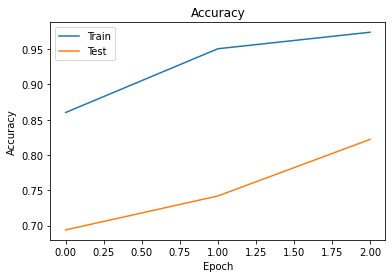

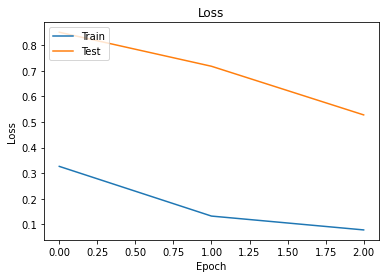

In [0]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

Save the model

In [0]:
modelv3.save('/content/gdrive/My Drive/pneumonia/inceptionv3.h5')

Validation prepare to test prediction

In [0]:
validationInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/val/"
labelsValidation, imagesValidation = extractData(validationInput)
labelsValidation = to_categorical(labelsValidation, 2)
print("Validation:", imagesValidation.shape)
print("Validation:", labelsValidation.shape)

100%|██████████| 9/9 [00:00<00:00, 19.05it/s]

Validation: (16, 199, 199, 3)
Validation: (16, 2)


We have 16 images in validation, as we see its nearly predict some images, and 
gives an understanding about the remaining images


In [0]:
predictions = modelv3.predict(imagesValidation)
predictions = predictions.reshape(1,-1)[0]
predictions[:16]

array([0.820575  , 0.17942497, 0.9754052 , 0.02459478, 0.668429  ,
       0.33157095, 0.42328963, 0.57671034, 0.6364238 , 0.36357614,
       0.6594696 , 0.34053034, 0.5847844 , 0.4152156 , 0.9976681 ,
       0.00233192], dtype=float32)